# Projet Datascientest - Compagnon immo

<code>mar25_bds_compagnon_immo_1</code>


---

## Modélisation prix de vente au m²- v1.0

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# sklearn
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor
# dump / load
import joblib

In [47]:
df_prices_2024 = pd.read_csv('../data/processed/dvf_data_2024_merged_transformed.csv.gz')

display(df_prices_2024.head())

display(df_prices_2024.shape)

,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,code_commune,code_departement,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,...,nombre_pieces_principales,code_nature_culture,code_nature_culture_speciale,surface_terrain,longitude,latitude,prix_m2_vente,annee,mois,hashed_code_commune
0,2024-01-02,1,1,346.5,1076,1,0,0.0,0,0.0,...,0.0,0.033424,0.972004,99.0,5.530952,45.952439,3.500000,2024,1,1076
1,2024-01-03,2,1,10000.0,1103,1,0,0.0,0,0.0,...,0.0,0.355449,0.972004,115.0,6.043339,46.282256,86.956522,2024,1,1103
2,2024-01-08,1,1,249000.0,1203,1,0,0.0,0,0.0,...,0.0,0.355449,0.972004,497.0,4.911143,46.247235,501.006036,2024,1,1203
3,2024-01-03,1,1,329500.0,1173,1,50,0.0,0,0.0,...,0.0,0.394142,0.972004,0.0,6.058695,46.332212,0.000000,2024,1,1173
4,2024-01-09,1,1,20000.0,1185,1,0,0.0,0,0.0,...,0.0,0.005397,0.972004,1584.0,5.548635,45.900606,12.626263,2024,1,1185


(1201891, 30)

### Valeurs extrêmes / aberrantes

In [49]:
# Suppression des lignes prix à 0
# On les a gardé dans notre dataset pour la partie valeur foncière
df_prices_2024 = df_prices_2024[df_prices_2024['prix_m2_vente'] != 0]
# On supprime les valeurs aberrantes / extrêmes
df_prices_2024 = df_prices_2024[(df_prices_2024['prix_m2_vente'] > 20) & (df_prices_2024['prix_m2_vente'] < 100000)]

df_prices_2024 = df_prices_2024[(df_prices_2024['valeur_fonciere'] > 1000) & (df_prices_2024['valeur_fonciere'] < 1000000)]

df_prices_2024 = df_prices_2024[df_prices_2024['lot1_numero'] < 1000000]

df_prices_2024 = df_prices_2024[df_prices_2024['surface_terrain'] < 100000]

# on supprime la variable date_mutation elle sert pour la modélisation de l'évolution des prix 
df_prices_2024 = df_prices_2024.drop('date_mutation', axis=1)

<div class="alert alert-info">
<i class="fa fa-info-circle"></i> Nous cherchons à prédire une variable quantitative, ce qui nécessite l'utilisation d'un modèle de régression.
</div>

### Train Test Split

In [51]:
X = df_prices_2024.drop(columns=['prix_m2_vente'])
y = df_prices_2024['prix_m2_vente']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Standardisation / Normalisation

In [53]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

---
## Sans réduction de dimension
---

### Entraînement des modèles

In [55]:
# Approche naïve pour commencer
n_estimators = 100
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "RandomForest": RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=n_estimators, learning_rate=0.1)
}

model_scores = []
best_pred = None
best_model_name = None
best_score = float('inf')

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
   
    # Dump des modèles entraînés
    joblib.dump(model, f"../models/{name}.pkl")
    
    # Métriques
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    if mae < best_score:
        best_score = mae
        best_model_name = name
        best_pred = y_pred
    
    model_scores.append({"Modèle": name, "MAE": mae, "MSE": mse, "RMSE": rmse, "R²": r2})

print(f"Meilleur modèle : {best_model_name} avec MAE = {best_score:.2f}")

Meilleur modèle : RandomForest avec MAE = 9.96


### Evaluation modèles entraînés

In [57]:
df_scores = pd.DataFrame(model_scores)
df_scores

,Modèle,MAE,MSE,RMSE,R²
0,LinearRegression,1472.555815,1.367744e+07,3698.302736,0.191322
1,Ridge,1472.556544,1.367744e+07,3698.302774,0.191322
2,Lasso,1472.543652,1.367742e+07,3698.299782,0.191324
3,RandomForest,9.955601,2.111369e+04,145.305519,0.998752
4,XGBoost,128.205293,9.165127e+05,957.346687,0.945811


In [59]:
mape = np.mean(np.abs((y_test - best_pred) / y_test)) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 0.28%


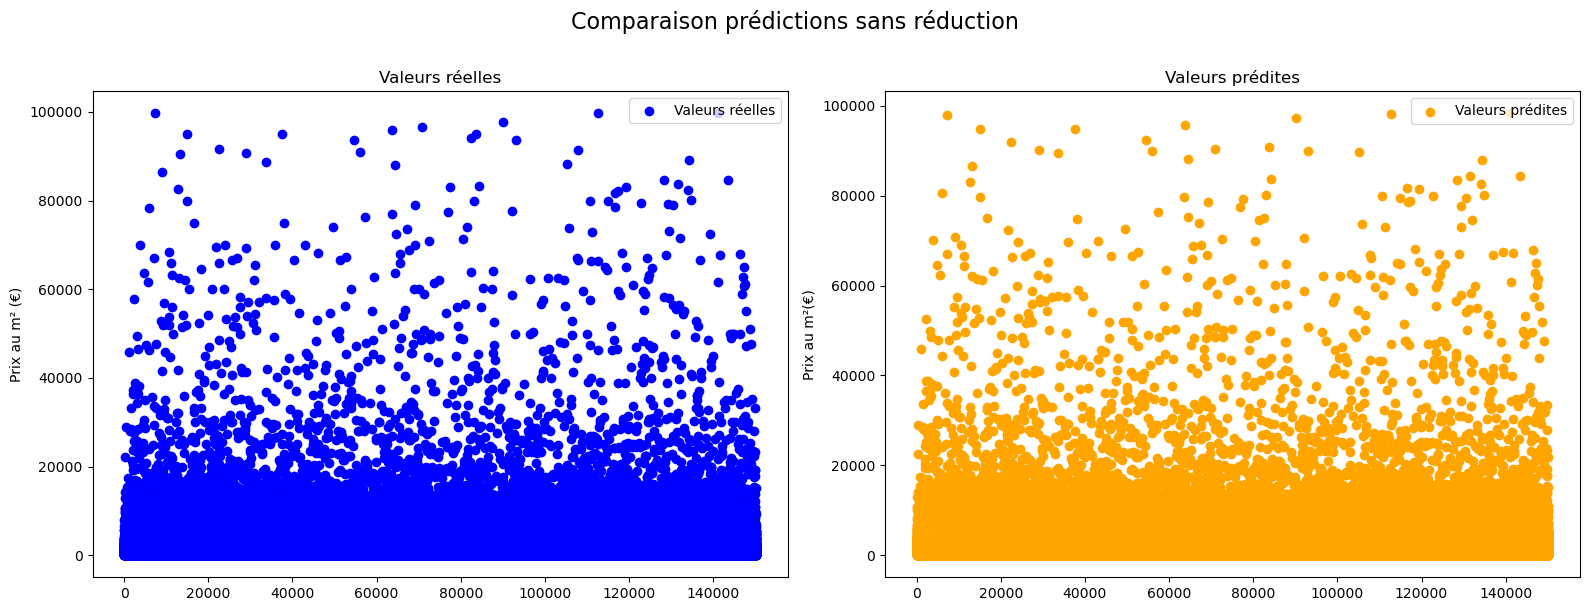

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.scatter(range(len(y_test)), y_test, color='b', label='Valeurs réelles')
ax1.set_title('Valeurs réelles')
ax1.set_ylabel('Prix au m² (€)')
ax1.legend()

ax2.scatter(range(len(y_test)), best_pred, color='orange', label='Valeurs prédites')
ax2.set_title('Valeurs prédites')
ax2.set_ylabel('Prix au m²(€)')
ax2.legend()

plt.suptitle('Comparaison prédictions sans réduction', fontsize=16, y=1.01)
plt.tight_layout()
plt.show();

---
## Avec réduction de dimension
---

In [17]:
# Approche naïve pour commencer
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_train)

print(f"Variance expliquée : {sum(pca.explained_variance_ratio_):.2f}")

Variance expliquée : 1.00


### Entraînement des modèles

In [19]:
model_pca_scores = []
best_pca_pred = None
best_model__pca_name = None
best_score_pca = float('inf')

models_pca = {
    "LinearRegression_pca": LinearRegression(),
    "Ridge_PCA": Ridge(alpha=1.0),
    "RandomForest_PCA": RandomForestRegressor(n_estimators=100, n_jobs=-1),
    "XGBoost_PCA": XGBRegressor(n_estimators=100, learning_rate=0.1)
}
for name, model in models_pca.items():
    model.fit(X_train, y_train)
    y_pred_pca = model.predict(X_test)

    # Dump des modèles entraînés
    joblib.dump(model, f"../models/{name}.pkl")

    # Métriques
    mae = mean_absolute_error(y_test, y_pred_pca)
    mse = mean_squared_error(y_test, y_pred_pca)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_pca))
    r2 = r2_score(y_test, y_pred_pca)

    if mae < best_score_pca:
        best_score_pca = mae
        best_model_pca_name = name
        best_pca_pred = y_pred_pca
    
    model_pca_scores.append({"Modèle": name, "MAE": mae, "MSE": mse, "RMSE": rmse, "R²": r2})

print(f"Meilleur modèle : {best_model_pca_name} avec MAE = {best_score_pca:.2f}")

Meilleur modèle : RandomForest_PCA avec MAE = 9.90


### Evaluation modèles avec réduction entraînés

In [61]:
df_pca_scores = pd.DataFrame(model_pca_scores)
df_pca_scores

,Modèle,MAE,MSE,RMSE,R²
0,LinearRegression_pca,1472.555815,1.367744e+07,3698.302736,0.191322
1,Ridge_PCA,1472.556544,1.367744e+07,3698.302774,0.191322
2,RandomForest_PCA,9.898111,2.045673e+04,143.027025,0.998790
3,XGBoost_PCA,128.205293,9.165127e+05,957.346687,0.945811


In [63]:
mape = np.mean(np.abs((y_test - best_pca_pred) / y_test)) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 0.28%


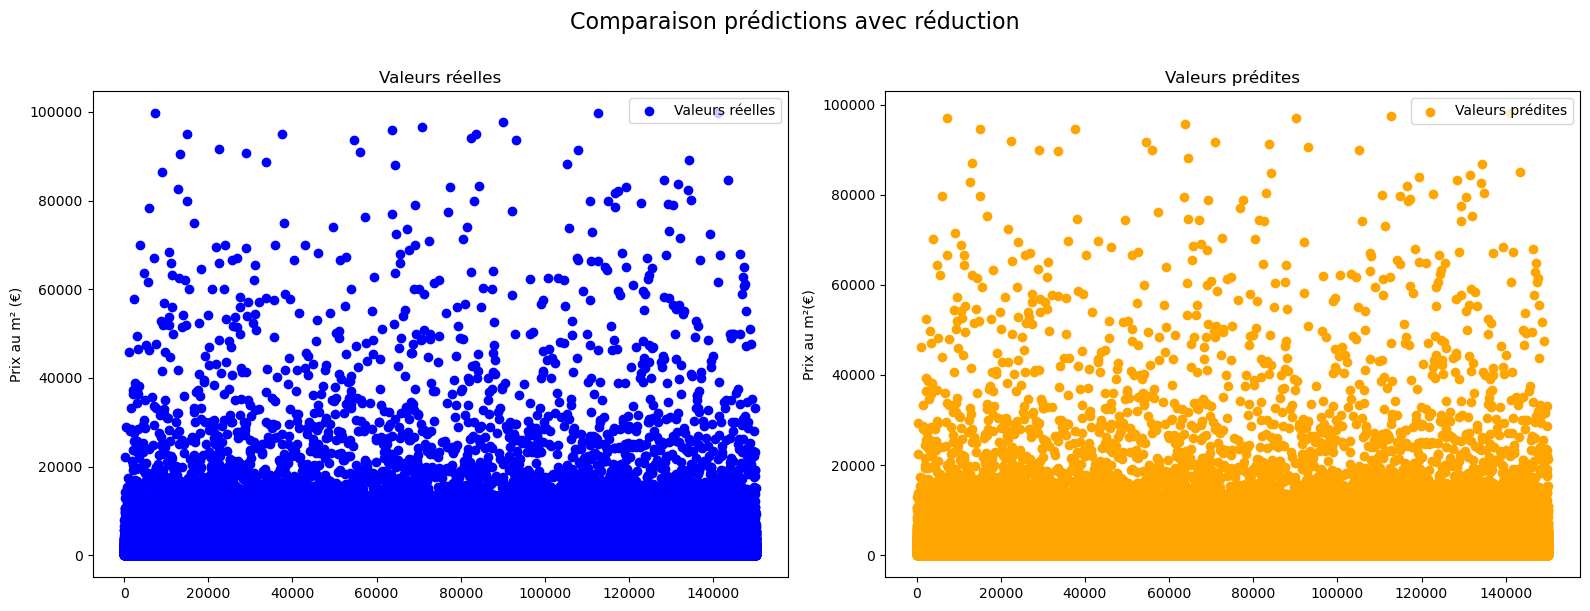

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.scatter(range(len(y_test)), y_test, color='b', label='Valeurs réelles')
ax1.set_title('Valeurs réelles')
ax1.set_ylabel('Prix au m² (€)')
ax1.legend()

ax2.scatter(range(len(y_test)), best_pca_pred, color='orange', label='Valeurs prédites')
ax2.set_title('Valeurs prédites')
ax2.set_ylabel('Prix au m²(€)')
ax2.legend()

plt.suptitle('Comparaison prédictions avec réduction', fontsize=16, y=1.01)
plt.tight_layout()
plt.show();